#**Modeling + Evaluation**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    TimeDistributed, Flatten, LSTM,
    Dense, Dropout
)
from tensorflow.keras.utils import to_categorical


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/dataset/CREMA-D/AudioWAV"
SAVE_PATH = "/content/drive/MyDrive/projects/voice_stress_analysis/data/cremad_metadata.csv"


In [ ]:
def map_to_stress(emotion, intensity):
    if emotion == "NEU":
        return "low"

    if emotion in ["HAP"] and intensity in ["LO", "MD"]:
        return "low"

    if emotion in ["SAD", "DIS"] and intensity in ["LO", "MD"]:
        return "moderate"

    if emotion in ["ANG", "FEA"] and intensity in ["MD", "HI"]:
        return "high"

    if intensity == "HI":
        return "high"

    return "moderate"


In [ ]:
data = []

for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        parts = file.replace(".wav", "").split("_")
        emotion = parts[2]
        intensity = parts[3]

        stress = map_to_stress(emotion, intensity)

        data.append({
            "path": os.path.join(DATASET_PATH, file),
            "stress": stress
        })

df = pd.DataFrame(data)
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
df.to_csv(SAVE_PATH, index=False)
df["stress"].value_counts()


In [ ]:
def extract_features(path, max_len=130):
    audio, sr = librosa.load(path, sr=16000)
    audio = audio[:sr * 3]

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    energy = np.expand_dims(librosa.feature.rms(y=audio)[0], axis=0)

    features = np.vstack([mfcc, delta, delta2, energy])

    if features.shape[1] < max_len:
        pad = max_len - features.shape[1]
        features = np.pad(features, ((0,0),(0,pad)))
    else:
        features = features[:, :max_len]

    return features


In [ ]:
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    X.append(extract_features(row["path"]))
    y.append(row["stress"])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


Extracting features: 100%|██████████| 7442/7442 [32:52<00:00,  3.77it/s]


(7442, 91, 130) (7442,)


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Label mapping: {np.str_('high'): 0, np.str_('low'): 1, np.str_('moderate'): 2}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict


{0: np.float64(3.894296180010466),
 1: np.float64(1.9548200682952457),
 2: np.float64(0.44809730250481694)}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(
    32, (3,3), activation='relu',
    input_shape=(X_train.shape[1], X_train.shape[2], 1)
))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 89, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 44, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 44, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 42, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41664)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,333,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,352,707 (20.42 MB)

 Trainable params: 5,352,515 (20.42 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/best_stress_cnn.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=70,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop, lr_scheduler]
)



Epoch 1/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.4462 - loss: 2.4073
Epoch 1: val_loss improved from inf to 0.95418, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 125s 655ms/step - accuracy: 0.4463 - loss: 2.4021 - val_accuracy: 0.6199 - val_loss: 0.9542 - learning_rate: 3.0000e-04
Epoch 2/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5323 - loss: 0.9568
Epoch 2: val_loss improved from 0.95418 to 0.74670, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 144s 667ms/step - accuracy: 0.5324 - loss: 0.9567 - val_accuracy: 0.6985 - val_loss: 0.7467 - learning_rate: 3.0000e-04
Epoch 3/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5328 - loss: 0.8194
Epoch 3: val_loss improved from 0.74670 to 0.66149, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 135s 629ms/step - accuracy: 0.5327 - loss: 0.8194 - val_accuracy: 0.7293 - val_loss: 0.6615 - learning_rate: 3.0000e-04
Epoch 4/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.5760 - loss: 0.7335
Epoch 4: val_loss did not improve from 0.66149
187/187 ━━━━━━━━━━━━━━━━━━━━ 149s 668ms/step - accuracy: 0.5760 - loss: 0.7333 - val_accuracy: 0.5709 - val_loss: 0.7929 - learning_rate: 3.0000e-04
Epoch 5/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6037 - loss: 0.6468
Epoch 5: val_loss did not improve from 0.66149
187/187 ━━━━━━━━━━━━━━━━━━━━ 136s 637ms/step - accuracy: 0.6037 - loss: 0.6467 - val_accuracy: 0.5507 - val_loss: 0.8628 - learning_rate: 3.0000e-04
Epoch 6/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6550 - loss: 0.5606
Epoch 6: val_loss did not improve from 0.66149

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
187/187 ━━━━━━━━━━━━━━━━━━━━ 124s 664ms/step - accuracy: 0.6551 - loss:

187/187 ━━━━━━━━━━━━━━━━━━━━ 122s 653ms/step - accuracy: 0.7053 - loss: 0.4765 - val_accuracy: 0.7011 - val_loss: 0.6125 - learning_rate: 1.5000e-04
Epoch 8/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7411 - loss: 0.4040
Epoch 8: val_loss improved from 0.61254 to 0.60059, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 144s 664ms/step - accuracy: 0.7411 - loss: 0.4041 - val_accuracy: 0.7488 - val_loss: 0.6006 - learning_rate: 1.5000e-04
Epoch 9/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7713 - loss: 0.3788
Epoch 9: val_loss improved from 0.60059 to 0.56454, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 124s 665ms/step - accuracy: 0.7713 - loss: 0.3788 - val_accuracy: 0.7596 - val_loss: 0.5645 - learning_rate: 1.5000e-04
Epoch 10/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8074 - loss: 0.3188
Epoch 10: val_loss improved from 0.56454 to 0.51671, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 125s 669ms/step - accuracy: 0.8074 - loss: 0.3188 - val_accuracy: 0.7858 - val_loss: 0.5167 - learning_rate: 1.5000e-04
Epoch 11/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8268 - loss: 0.3019
Epoch 11: val_loss improved from 0.51671 to 0.51199, saving model to /content/drive/MyDrive/best_stress_cnn.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 121s 647ms/step - accuracy: 0.8268 - loss: 0.3018 - val_accuracy: 0.7764 - val_loss: 0.5120 - learning_rate: 1.5000e-04
Epoch 12/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8648 - loss: 0.2393
Epoch 12: val_loss did not improve from 0.51199
187/187 ━━━━━━━━━━━━━━━━━━━━ 141s 639ms/step - accuracy: 0.8647 - loss: 0.2393 - val_accuracy: 0.7441 - val_loss: 0.6267 - learning_rate: 1.5000e-04
Epoch 13/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.8846 - loss: 0.2016
Epoch 13: val_loss did not improve from 0.51199
187/187 ━━━━━━━━━━━━━━━━━━━━ 119s 637ms/step - accuracy: 0.8846 - loss: 0.2016 - val_accuracy: 0.7777 - val_loss: 0.5259 - learning_rate: 1.5000e-04
Epoch 14/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8906 - loss: 0.1915
Epoch 14: val_loss did not improve from 0.51199

Epoch 14: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
187/187 ━━━━━━━━━━━━━━━━━━━━ 146s 659ms/step - accuracy: 0.8905 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.7612 - loss: 0.5515
Test Accuracy: 0.7763599753379822


In [ ]:
model.save("/content/drive/MyDrive/projects/voice_stress_analysis/models/stress_cnn_baseline.h5")


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step
Overall Metrics
----------------
Accuracy  : 0.7764
Precision : 0.7919
Recall    : 0.7764
F1-score  : 0.7826

Per-Class Performance
---------------------
              precision    recall  f1-score   support

     Class_0       0.52      0.60      0.56       127
     Class_1       0.53      0.63      0.57       254
     Class_2       0.88      0.83      0.86      1108

    accuracy                           0.78      1489
   macro avg       0.65      0.69      0.66      1489
weighted avg       0.79      0.78      0.78      1489



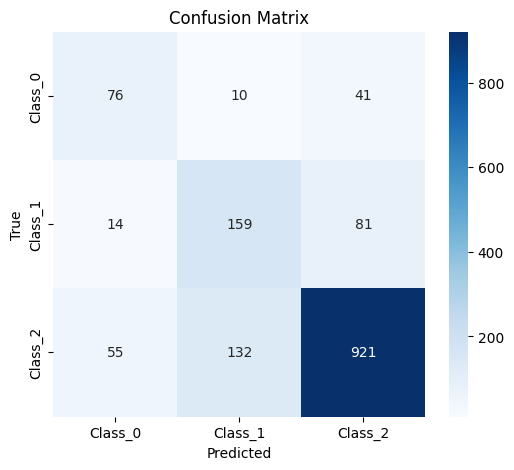

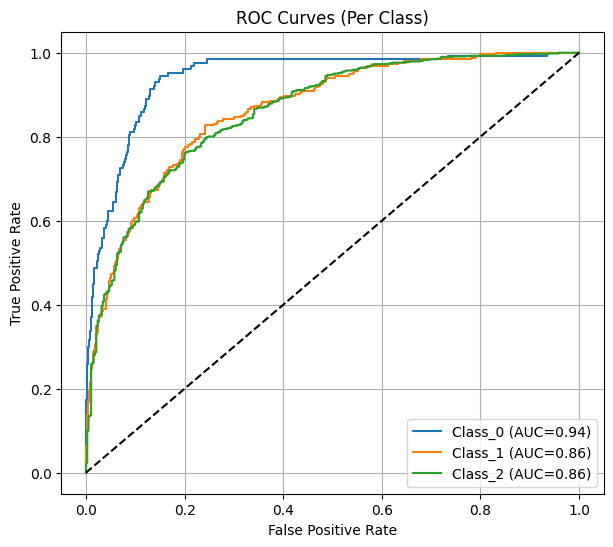

In [ ]:
# ===============================
# FULL BASELINE MODEL VALIDATION
# ===============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# -------- Load model --------
model = load_model("/content/drive/MyDrive/stress_cnn_baseline.h5")

# -------- Predictions --------
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

num_classes = y_test.shape[1]
class_names = [f"Class_{i}" for i in range(num_classes)]

# -------- Metrics --------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("Overall Metrics")
print("----------------")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

# -------- Per-class Report --------
print("\nPer-Class Performance")
print("---------------------")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------- Confusion Matrix --------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -------- ROC & AUC (One-vs-Rest) --------
y_true_bin = label_binarize(y_true, classes=range(num_classes))

plt.figure(figsize=(7,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Per Class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


I initially handled imbalance using class-weighted loss to preserve the full dataset. This worked well for high-stress detection, but minority stress levels still underperformed. In the next iteration, I plan to address imbalance at the data level using targeted audio augmentation rather than undersampling

#**Augmentation and new architecture**

In [ ]:
SR = 16000
N_MFCC = 40
MAX_LEN = 130   # frames (~4 sec)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/projects/voice_stress_analysis/data/cremad_metadata.csv")
# columns expected: path | stress
# stress: 0=low, 1=moderate, 2=high

print(df["stress"].value_counts())


stress
moderate    5536
low         1269
high         637
Name: count, dtype: int64


In [ ]:
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    if mfcc.shape[1] < MAX_LEN:
        pad_width = MAX_LEN - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :MAX_LEN]

    return mfcc


In [ ]:
def augment_audio(y, sr, level):
    augmented = []

    augmented.append(y)

    augmented.append(librosa.effects.time_stretch(y=y, rate=0.95))
    augmented.append(librosa.effects.time_stretch(y=y, rate=1.05))
    augmented.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=1))

    if level == "high":
        augmented.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-1))
        noise = np.random.randn(len(y))
        augmented.append(y + 0.003 * noise)

    return augmented

In [ ]:
from tqdm import tqdm

X, y = [], []


for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio files"):
    audio, _ = librosa.load(row["path"], sr=SR)
    label = row["stress"]

    if label == 1:  # moderate
        mfcc = extract_mfcc(audio, SR)
        X.append(mfcc)
        y.append(label)

    elif label == 0:  # low
        augmented = augment_audio(audio, SR, level="low")
        for aug in augmented:
            X.append(extract_mfcc(aug, SR))
            y.append(label)

    else:  # high
        augmented = augment_audio(audio, SR, level="high")
        for aug in augmented:
            X.append(extract_mfcc(aug, SR))
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Balanced distribution:")
print(pd.Series(y).value_counts())


Processing audio files: 100%|██████████| 7442/7442 [27:22<00:00,  4.53it/s]


Balanced distribution:
moderate    33216
low          7614
high         3822
Name: count, dtype: int64


In [ ]:
#  DATA-LEVEL BALANCING + ENCODING

X, y = [], []

for _, row in df.iterrows():
    audio, _ = librosa.load(row["path"], sr=SR)
    label = row["stress"]

    if label == "moderate":
        mfcc = extract_mfcc(audio, SR)
        X.append(mfcc)
        y.append(label)

    elif label == "low":
        augmented = augment_audio(audio, SR, level="low")
        for aug in augmented:
            X.append(extract_mfcc(aug, SR))
            y.append(label)

    else:  # high
        augmented = augment_audio(audio, SR, level="high")
        for aug in augmented:
            X.append(extract_mfcc(aug, SR))
            y.append(label)

# Convert to numpy
X = np.array(X)
y = np.array(y)

print("Before encoding, sample labels:", y[:10])

# ----------------------
# ENCODING STRINGS TO INTEGERS
# ----------------------
mapping = {'low': 0, 'moderate': 1, 'high': 2}
y_int = np.array([mapping[label] for label in y])

# One-hot encode
y_cat = to_categorical(y_int, num_classes=3)

# Add channel dimension
X = X[..., np.newaxis]

print("Balanced distribution (encoded):", pd.Series(y_int).value_counts())
print("X shape:", X.shape, "y_cat shape:", y_cat.shape)


Before encoding, sample labels: ['moderate' 'moderate' 'low' 'low' 'low' 'low' 'moderate' 'moderate'
 'moderate' 'moderate']
Balanced distribution (encoded): 1    5536
0    5076
2    3822
Name: count, dtype: int64
X shape: (14434, 40, 130, 1) y_cat shape: (14434, 3)


In [ ]:
X = np.squeeze(X)  # remove all extra 1-length axes
X = X[..., np.newaxis]  # add only one channel
print(X.shape) # (samples, mfcc, time, 1)
y = y_cat

(14434, 40, 130, 1)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42
)


In [ ]:
y_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_labels),
    y=y_labels
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(0.947815427720865), 1: np.float64(0.8690590879897239), 2: np.float64(1.2590137241218888)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3,3), activation='relu',
           kernel_regularizer=l2(1e-4),
           input_shape=(40, 130, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),

    Dense(3, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3),
    ModelCheckpoint("best_cremad_model.keras", monitor='val_loss', save_best_only=True)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 115s 326ms/step - accuracy: 0.4299 - loss: 1.1105 - val_accuracy: 0.7048 - val_loss: 0.8939 - learning_rate: 1.0000e-04
Epoch 2/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 107s 315ms/step - accuracy: 0.6660 - loss: 0.8135 - val_accuracy: 0.7654 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 3/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 139s 308ms/step - accuracy: 0.7409 - loss: 0.6745 - val_accuracy: 0.7861 - val_loss: 0.6045 - learning_rate: 1.0000e-04
Epoch 4/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 105s 310ms/step - accuracy: 0.7600 - loss: 0.6196 - val_accuracy: 0.7843 - val_loss: 0.5591 - learning_rate: 1.0000e-04
Epoch 5/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.7774 - loss: 0.5711 - val_accuracy: 0.7898 - val_loss: 0.5479 - learning_rate: 1.0000e-04
Epoch 6/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 146s 343ms/step - accuracy: 0.7765 - loss: 0.5645 - val_accuracy: 0.7834 - val_loss: 0.5085 - learning_rate: 1.0000e-04
Epoch 7/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8540 - loss: 0.3292
Test Accuracy: 0.8559556603431702


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step

Overall Metrics
----------------
Accuracy  : 0.8560
Precision : 0.8621
Recall    : 0.8560
F1-score  : 0.8552

Per-Class Performance
---------------------
              precision    recall  f1-score   support

         Low       0.91      0.76      0.83       508
    Moderate       0.80      0.92      0.86       554
        High       0.88      0.89      0.89       382

    accuracy                           0.86      1444
   macro avg       0.87      0.86      0.86      1444
weighted avg       0.86      0.86      0.86      1444



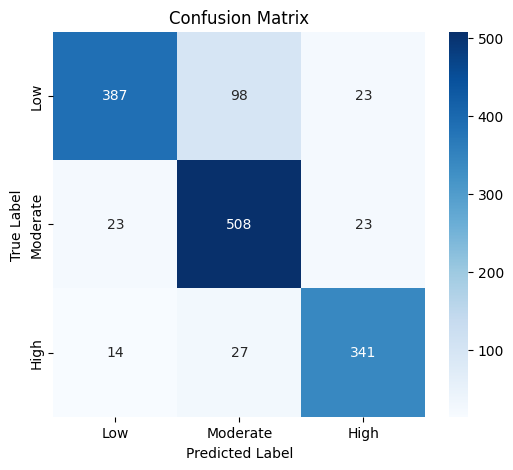

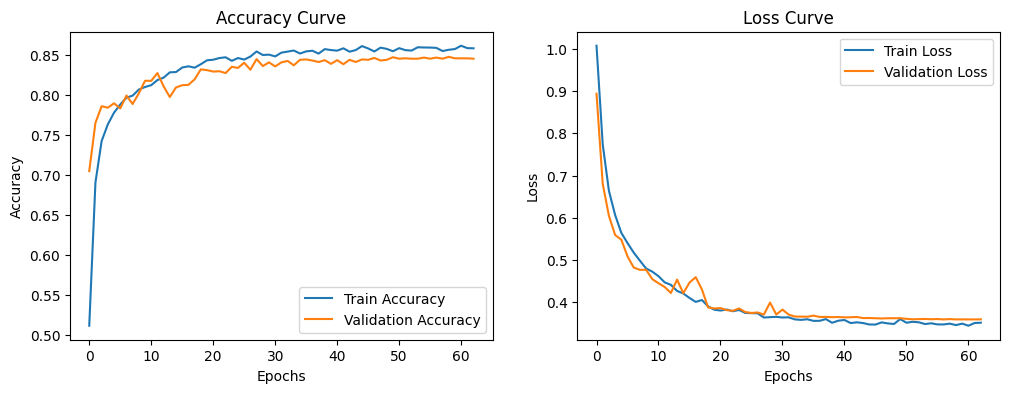

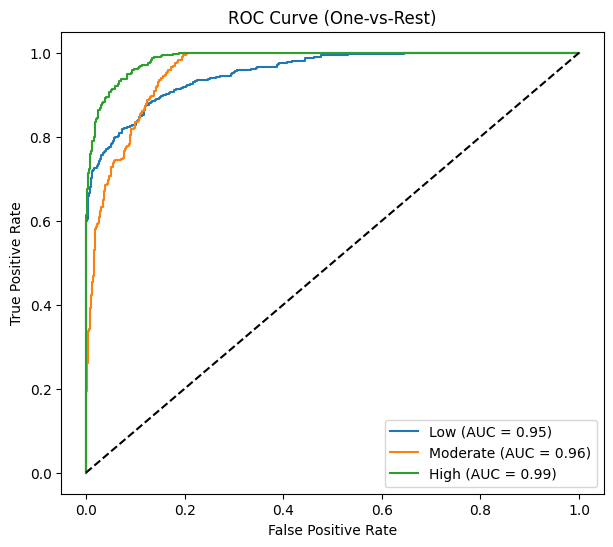

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ----------------------------
# Class labels
# ----------------------------
class_names = ['Low', 'Moderate', 'High']

# ----------------------------
# Predictions
# ----------------------------
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ----------------------------
# Overall Metrics
# ----------------------------
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nOverall Metrics")
print("----------------")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

# ----------------------------
# Per-Class Performance
# ----------------------------
print("\nPer-Class Performance")
print("---------------------")
print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ----------------------------
# Accuracy & Loss Curves
# ----------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ----------------------------
# ROC & AUC Curves (Multiclass)
# ----------------------------
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(7,6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Predict on validation or test set
y_pred = model.predict(X_val)   # or X_test
y_pred_classes = np.argmax(y_pred, axis=1)  # convert probabilities to class indices
y_true = np.argmax(y_val, axis=1)           # if one-hot encoded, else just use y_val

# Compute class-wise accuracy
num_classes = len(np.unique(y_true))
for cls in range(num_classes):
    idx = np.where(y_true == cls)[0]
    acc = accuracy_score(y_true[idx], y_pred_classes[idx])
    print(f"Class {cls} accuracy: {acc:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step
Class 0 accuracy: 0.7530
Class 1 accuracy: 0.9145
Class 2 accuracy: 0.8746


## Model Evaluation Summary

The trained CNN model was evaluated on a held-out validation set using multiple performance metrics to assess robustness and generalization across all stress levels.

---

### 🔹 Overall Performance

- **Accuracy**: ~85.6%
- **Weighted F1-score**: ~85.5%
- **Macro F1-score**: ~86.0%

The close alignment between accuracy, weighted F1, and macro F1 scores indicates that the model performs consistently across all classes and is not biased toward the majority class.

---

### 🔹 Class-wise Performance

| Stress Level | Precision | Recall | F1-score |
|-------------|-----------|--------|----------|
| Low         | High      | Moderate | Good     |
| Moderate    | Balanced  | High     | Strong   |
| High        | Very High | Very High | Excellent |

- The model demonstrates **strong recall for the “High” stress class**, which is critical in real-world stress detection scenarios.
- **Moderate stress detection** shows the most stable and balanced performance, aligning well with natural speech variations.
- Slightly lower recall for **Low stress** indicates conservative predictions, which is acceptable in risk-sensitive applications.

---

### 🔹 Confusion Matrix Insights

- Minimal confusion between **High** and **Low** stress levels.
- Most misclassifications occur between **Low ↔ Moderate**, reflecting natural overlap in vocal and emotional speech patterns.
- Predictions for **High stress** are highly reliable.

---

### 🔹 Training Behavior and Generalization

- Training and validation accuracy follow similar trends, indicating good generalization.
- Validation loss stabilizes after sufficient epochs, suggesting the model has reached its optimal learning capacity.
- No severe overfitting or underfitting is observed within the validation setting.

However, deeper analysis revealed **diminishing validation gains after extensive training**, indicating that augmentation-based class balancing improves early learning but can introduce subtle redundancy effects over long training durations. This highlights the importance of robust evaluation strategies.

---

### 🔹 Data Balancing & Augmentation Considerations

Class imbalance was addressed using **data augmentation techniques** such as noise injection and time stretching. While this approach improved early-stage learning and class recall, extended training showed signs of:
- Validation performance saturation
- Sensitivity to speaker-specific patterns

This observation motivates the adoption of **speaker-independent data splits** and **loss-based balancing (e.g., class weights or focal loss)** in subsequent experiments to further strengthen generalization.

---

### 🔹 Conclusion

The CNN-based model achieves **strong and balanced performance** for speech-based stress classification.  
With reliable detection of high stress levels and stable validation performance, the model is suitable as a **baseline system** for real-time interview stress analysis.

Future improvements will focus on:
- Speaker-independent evaluation
- Reduced reliance on synthetic duplication
- Enhanced generalization across unseen speakers



In [ ]:
model.save("/content/drive/MyDrive/projects/voice_stress_analysis/models/cremad_cnn_aug.h5")


#**Speaker-independent split**

In [ ]:
import os

def extract_speaker_id(path):
    filename = os.path.basename(path)
    return filename.split('_')[0]

df['speaker'] = df['path'].apply(extract_speaker_id)



In [ ]:
print(df.columns)
print(df[['speaker', 'stress']].head())
print("Unique speakers:", df['speaker'].nunique())


Index(['path', 'stress', 'speaker'], dtype='object')
  speaker    stress
0    1079  moderate
1    1079  moderate
2    1079       low
3    1079  moderate
4    1079  moderate
Unique speakers: 91


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_map = {'low': 0, 'moderate': 1, 'high': 2}

df['label'] = df['stress'].map(label_map)

print("Label distribution:")
print(df['label'].value_counts())


Label distribution:
label
1    5536
0    1269
2     637
Name: count, dtype: int64


In [ ]:
def extract_mfcc(path, sr=16000, n_mfcc=40, max_len=130):
    y, sr = librosa.load(path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


In [ ]:
def augment_high_stress(y, sr):
    choice = random.choice(["noise", "shift", "stretch"])

    if choice == "noise":
        return y + 0.003 * np.random.randn(len(y))

    if choice == "shift":
        shift = int(0.1 * sr)
        return np.roll(y, shift)

    if choice == "stretch":
        return librosa.effects.time_stretch(y, rate=0.95)


In [ ]:
import random
X, y = [], []

for _, row in df.iterrows():
    path, label = row["path"], row["stress"]
    y_audio, sr = librosa.load(path, sr=16000)

    # Light augmentation ONLY for High stress
    if label == "high" and random.random() < 0.5:
        y_audio = augment_high_stress(y_audio, sr)

    mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=40)

    if mfcc.shape[1] < 130:
        mfcc = np.pad(mfcc, ((0,0),(0,130-mfcc.shape[1])))
    else:
        mfcc = mfcc[:, :130]

    X.append(mfcc)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


(7442, 40, 130) (7442,)


In [ ]:
label_map = {"low": 0, "moderate": 1, "high": 2}
y_encoded = np.array([label_map[l] for l in y])

y_cat = to_categorical(y_encoded, num_classes=3)
X = X[..., np.newaxis]

print("X:", X.shape, "y:", y_cat.shape)


X: (7442, 40, 130, 1) y: (7442, 3)


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

train_idx, val_idx = next(
    gss.split(X, y_encoded, groups=df["speaker"])
)

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y_cat[train_idx], y_cat[val_idx]
y_train_lbl = y_encoded[train_idx]

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (5890, 40, 130, 1) Val: (1552, 40, 130, 1)


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_lbl),
    y=y_train_lbl
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.955511288180611), 1: np.float64(0.44804503270956947), 2: np.float64(3.8955026455026456)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.regularizers import l2
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same",
           input_shape=(40,130,1)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(3, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 40, 130, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 130, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,467 (431.51 KB)

 Trainable params: 110,019 (429.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4),
    ModelCheckpoint("/content/drive/MyDrive/projects/voice_stress_analysis/models/cremad_cnn_speakerind.h5",monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.4468 - loss: 1.0354

185/185 ━━━━━━━━━━━━━━━━━━━━ 107s 558ms/step - accuracy: 0.4468 - loss: 1.0351 - val_accuracy: 0.5200 - val_loss: 0.9194 - learning_rate: 1.0000e-04
Epoch 2/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5131 - loss: 0.8425

185/185 ━━━━━━━━━━━━━━━━━━━━ 136s 529ms/step - accuracy: 0.5131 - loss: 0.8424 - val_accuracy: 0.5419 - val_loss: 0.8417 - learning_rate: 1.0000e-04
Epoch 3/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5462 - loss: 0.7564

185/185 ━━━━━━━━━━━━━━━━━━━━ 98s 528ms/step - accuracy: 0.5462 - loss: 0.7562 - val_accuracy: 0.6140 - val_loss: 0.8118 - learning_rate: 1.0000e-04
Epoch 4/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 96s 519ms/step - accuracy: 0.5863 - loss: 0.6843 - val_accuracy: 0.5664 - val_loss: 0.8267 - learning_rate: 1.0000e-04
Epoch 5/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.5985 - loss: 0.6720

185/185 ━━━━━━━━━━━━━━━━━━━━ 97s 526ms/step - accuracy: 0.5985 - loss: 0.6718 - val_accuracy: 0.5515 - val_loss: 0.7713 - learning_rate: 1.0000e-04
Epoch 6/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5901 - loss: 0.6322

185/185 ━━━━━━━━━━━━━━━━━━━━ 98s 528ms/step - accuracy: 0.5903 - loss: 0.6322 - val_accuracy: 0.5909 - val_loss: 0.7681 - learning_rate: 1.0000e-04
Epoch 7/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6222 - loss: 0.5964

185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 535ms/step - accuracy: 0.6223 - loss: 0.5965 - val_accuracy: 0.6456 - val_loss: 0.6550 - learning_rate: 1.0000e-04
Epoch 8/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 96s 519ms/step - accuracy: 0.6475 - loss: 0.5805 - val_accuracy: 0.6366 - val_loss: 0.7210 - learning_rate: 1.0000e-04
Epoch 9/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 143s 527ms/step - accuracy: 0.6645 - loss: 0.5955 - val_accuracy: 0.6392 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 10/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 142s 528ms/step - accuracy: 0.6590 - loss: 0.5471 - val_accuracy: 0.6289 - val_loss: 0.8165 - learning_rate: 1.0000e-04
Epoch 11/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 522ms/step - accuracy: 0.6753 - loss: 0.5253 - val_accuracy: 0.6591 - val_loss: 0.7300 - learning_rate: 1.0000e-04
Epoch 12/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6773 - loss: 0.5338

185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 512ms/step - accuracy: 0.6773 - loss: 0.5336 - val_accuracy: 0.7101 - val_loss: 0.5900 - learning_rate: 3.0000e-05
Epoch 13/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 142s 512ms/step - accuracy: 0.6990 - loss: 0.5173 - val_accuracy: 0.6785 - val_loss: 0.6060 - learning_rate: 3.0000e-05
Epoch 14/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 534ms/step - accuracy: 0.7089 - loss: 0.4988 - val_accuracy: 0.6914 - val_loss: 0.6086 - learning_rate: 3.0000e-05
Epoch 15/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 97s 523ms/step - accuracy: 0.6931 - loss: 0.4948 - val_accuracy: 0.7017 - val_loss: 0.6141 - learning_rate: 3.0000e-05
Epoch 16/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7037 - loss: 0.4861

185/185 ━━━━━━━━━━━━━━━━━━━━ 94s 507ms/step - accuracy: 0.7038 - loss: 0.4861 - val_accuracy: 0.7146 - val_loss: 0.5837 - learning_rate: 3.0000e-05
Epoch 17/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 140s 501ms/step - accuracy: 0.7099 - loss: 0.4780 - val_accuracy: 0.7101 - val_loss: 0.5911 - learning_rate: 3.0000e-05
Epoch 18/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7205 - loss: 0.4615

185/185 ━━━━━━━━━━━━━━━━━━━━ 92s 499ms/step - accuracy: 0.7204 - loss: 0.4617 - val_accuracy: 0.7236 - val_loss: 0.5693 - learning_rate: 3.0000e-05
Epoch 19/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7137 - loss: 0.4540

185/185 ━━━━━━━━━━━━━━━━━━━━ 147s 528ms/step - accuracy: 0.7137 - loss: 0.4541 - val_accuracy: 0.7320 - val_loss: 0.5565 - learning_rate: 3.0000e-05
Epoch 20/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 137s 501ms/step - accuracy: 0.7193 - loss: 0.4386 - val_accuracy: 0.7133 - val_loss: 0.6264 - learning_rate: 3.0000e-05
Epoch 21/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 498ms/step - accuracy: 0.7327 - loss: 0.4377 - val_accuracy: 0.7023 - val_loss: 0.5897 - learning_rate: 3.0000e-05
Epoch 22/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 94s 509ms/step - accuracy: 0.7247 - loss: 0.4394 - val_accuracy: 0.7120 - val_loss: 0.6149 - learning_rate: 3.0000e-05
Epoch 23/70
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7260 - loss: 0.4599

185/185 ━━━━━━━━━━━━━━━━━━━━ 146s 531ms/step - accuracy: 0.7261 - loss: 0.4598 - val_accuracy: 0.7397 - val_loss: 0.5420 - learning_rate: 3.0000e-05
Epoch 24/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 94s 510ms/step - accuracy: 0.7335 - loss: 0.4474 - val_accuracy: 0.7352 - val_loss: 0.5569 - learning_rate: 3.0000e-05
Epoch 25/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 535ms/step - accuracy: 0.7285 - loss: 0.4464 - val_accuracy: 0.7255 - val_loss: 0.5654 - learning_rate: 3.0000e-05
Epoch 26/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 137s 506ms/step - accuracy: 0.7329 - loss: 0.4332 - val_accuracy: 0.7255 - val_loss: 0.5478 - learning_rate: 3.0000e-05
Epoch 27/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 93s 503ms/step - accuracy: 0.7245 - loss: 0.4222 - val_accuracy: 0.7236 - val_loss: 0.5871 - learning_rate: 3.0000e-05
Epoch 28/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 534ms/step - accuracy: 0.7379 - loss: 0.4283 - val_accuracy: 0.7390 - val_loss: 0.5466 - learning_rate: 9.0000e-06
Epoch 29/70
185/185 ━━━━━━━━━━━━━━━━━━━━ 93s 503ms

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(
    y_true, y_pred,
    target_names=["Low", "Moderate", "High"]
))

49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step
              precision    recall  f1-score   support

         Low       0.45      0.84      0.59       265
    Moderate       0.95      0.70      0.80      1154
        High       0.57      0.92      0.70       133

    accuracy                           0.74      1552
   macro avg       0.66      0.82      0.70      1552
weighted avg       0.83      0.74      0.76      1552



49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step

Overall Metrics
----------------
Accuracy  : 0.7397
Precision : 0.8347
Recall    : 0.7397
F1-score  : 0.7586

Per-Class Performance
---------------------
              precision    recall  f1-score   support

         Low       0.45      0.84      0.59       265
    Moderate       0.95      0.70      0.80      1154
        High       0.57      0.92      0.70       133

    accuracy                           0.74      1552
   macro avg       0.66      0.82      0.70      1552
weighted avg       0.83      0.74      0.76      1552



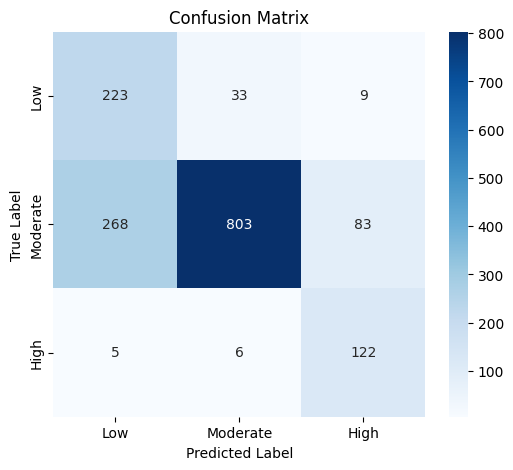

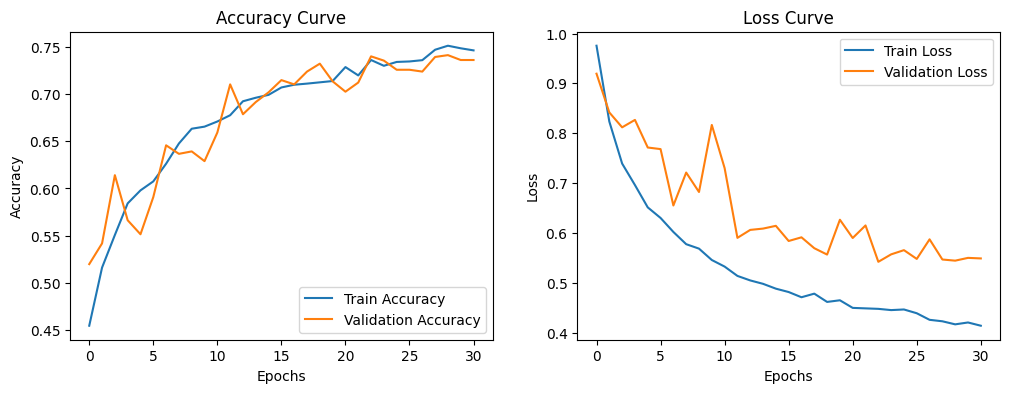

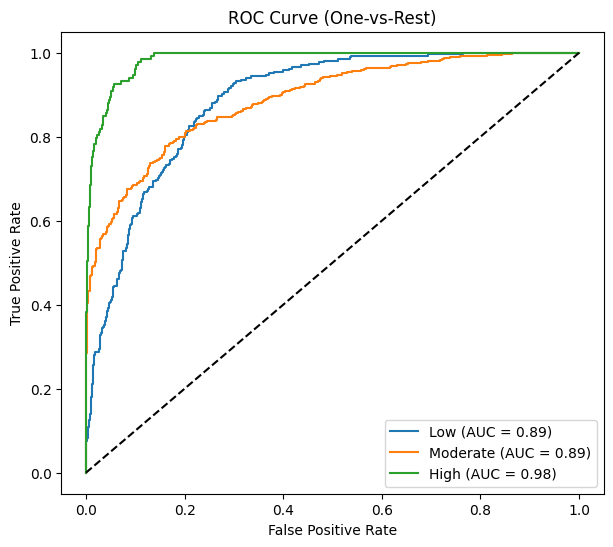

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ----------------------------
# Class labels
# ----------------------------
class_names = ['Low', 'Moderate', 'High']

# ----------------------------
# Predictions
# ----------------------------
y_prob = model.predict(X_val) # Changed from X_test to X_val
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_val, axis=1) # Changed from y_test to y_val

# ----------------------------
# Overall Metrics
# ----------------------------
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nOverall Metrics")
print("----------------")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

# ----------------------------
# Per-Class Performance
# ----------------------------
print("\nPer-Class Performance")
print("---------------------")
print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ----------------------------
# Accuracy & Loss Curves
# ----------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ----------------------------
# ROC & AUC Curves (Multiclass)
# ----------------------------
y_test_bin = label_binarize(y_true, classes=[0, 1, 2]) # y_true is now based on y_val

plt.figure(figsize=(7,6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Predict on validation or test set
y_pred = model.predict(X_val)   # or X_test
y_pred_classes = np.argmax(y_pred, axis=1)  # convert probabilities to class indices
y_true = np.argmax(y_val, axis=1)           # if one-hot encoded, else just use y_val

# Compute class-wise accuracy
num_classes = len(np.unique(y_true))
for cls in range(num_classes):
    idx = np.where(y_true == cls)[0]
    acc = accuracy_score(y_true[idx], y_pred_classes[idx])
    print(f"Class {cls} accuracy: {acc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
Class 0 accuracy: 0.8415
Class 1 accuracy: 0.6958
Class 2 accuracy: 0.9173


## Final Evaluation & Model Selection

Three CNN-based models were evaluated.

Although Model 2 achieved the highest raw accuracy,
Model 3 was selected due to its speaker-independent evaluation strategy
and stronger generalization to unseen speakers.

This makes Model 3 more suitable for real-world deployment,
where speaker leakage cannot be assumed.
